
# Neuropixels (Spinal Cord) Processing Pipeline — SpikeInterface + KS4

This notebook implements a ready-to-run pipeline for a **single Neuropixels probe** recording in the **spinal cord**, with time-locked triggers for **optogenetics**, **ICMS**, and **peripheral nerve** stimulation recorded via **NiDq** in SpikeGLX.

It loads your **exact folder structure on Windows**, performs preprocessing (band‑pass, notch, CAR), **artifact blanking** around stimulus pulses, optional **motion correction**, **Kilosort 4** spike sorting, **quality metrics + auto‑curation**, and exports to **Phy** and **NWB**. It also computes simple **PSTHs** per condition.



## Prerequisites

- Python 3.10+ (recommended)  
- `spikeinterface[full]` installed  
- Kilosort 4 installed and configured on your machine (CUDA + KS4 binaries)  
- SpikeGLX data with:
  - AP/LFP under the `..._imec0` subfolder
  - NiDq one folder up (same run)  


Helps the CUDA caching allocator avoid fragmentation on small GPUs


In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,max_split_size_mb:128,garbage_collection_threshold:0.9"


In [3]:
# --- Imports and helpers ---
import os
import json
import numpy as np

import spikeinterface.full as si
import spikeinterface.preprocessing as sp
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
from spikeinterface.preprocessing import correct_motion
import spikeinterface.qualitymetrics as sqm
from spikeinterface.exporters import export_to_phy
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt

In [4]:
%matplotlib widget
import matplotlib

matplotlib.use('module://ipympl.backend_nbagg')
backend = matplotlib.get_backend()
print(backend)  # This should print 'module://ipympl.backend_nbagg'
assert "ipympl" in backend, "ipympl backend is not set correctly"

module://ipympl.backend_nbagg


Loading All_g0 recording

In [5]:
from pathlib import Path
import re

# Windows paths to SpikeGLX data (keep raw r-strings due to spaces/backslashes)
IMECO_PATH = r"C:/storage/Reza/rat data/08-08-2025/ICMSstim_icmsstim_All_Concat_g0/ap_zarr.zarr"
NIDQ_PATH  = r"C:/storage/Reza/rat data/08-08-2025/ICMSstim_icmsstim_All_Concat_g0/nidq_zarr.zarr"

RESULTS_ROOT = Path("./results").resolve()  # change if you want a different root

def infer_out_dir(any_path: str) -> Path:
    p = Path(any_path)
    parts = p.parts

    # Find the date component like "08-08-2025" in the path
    date_idx = next((i for i, s in enumerate(parts) if re.fullmatch(r"\d{2}-\d{2}-\d{4}", s)), None)

    if date_idx is not None and date_idx + 1 < len(parts):
        date_dir = parts[date_idx]        # e.g., "08-08-2025"
        session_group = parts[date_idx+1] # e.g., "ICMSstim_icmsstim_2_g0"
    else:
        # Fallback: use immediate parent and name
        date_dir = p.parent.name
        session_group = p.name

    # Remove SpikeGLX run suffix like "_g0"
    session = re.sub(r"_g\d+$", "", session_group)

    out = (RESULTS_ROOT / date_dir / session).resolve()
    out.mkdir(parents=True, exist_ok=True)
    return out

# Pick whichever path you prefer to infer from (NIDQ is usually simplest)
OUT_DIR = infer_out_dir(NIDQ_PATH)

print("OUT_DIR:", OUT_DIR)

OUT_DIR: C:\storage\Reza\Neuropixel-pipeline\Test-Pipeline\results\08-08-2025\ICMSstim_icmsstim_All_Concat


Loading #_g0 recordings

In [6]:
# from pathlib import Path
# import re

# # Windows paths to SpikeGLX data (keep raw r-strings due to spaces/backslashes)
# IMECO_PATH = r"C:/storage/Reza/rat data/08-08-2025/ICMSstim_icmsstim_2_g0/ICMSstim_icmsstim_2_g0_imec0"
# NIDQ_PATH  = r"C:/storage/Reza/rat data/08-08-2025/ICMSstim_icmsstim_2_g0"

# RESULTS_ROOT = Path("./results").resolve()  # change if you want a different root

# def infer_out_dir(any_path: str) -> Path:
#     p = Path(any_path)
#     parts = p.parts

#     # Find the date component like "08-08-2025" in the path
#     date_idx = next((i for i, s in enumerate(parts) if re.fullmatch(r"\d{2}-\d{2}-\d{4}", s)), None)

#     if date_idx is not None and date_idx + 1 < len(parts):
#         date_dir = parts[date_idx]        # e.g., "08-08-2025"
#         session_group = parts[date_idx+1] # e.g., "ICMSstim_icmsstim_2_g0"
#     else:
#         # Fallback: use immediate parent and name
#         date_dir = p.parent.name
#         session_group = p.name

#     # Remove SpikeGLX run suffix like "_g0"
#     session = re.sub(r"_g\d+$", "", session_group)

#     out = (RESULTS_ROOT / date_dir / session).resolve()
#     out.mkdir(parents=True, exist_ok=True)
#     return out

# # Pick whichever path you prefer to infer from (NIDQ is usually simplest)
# OUT_DIR = infer_out_dir(NIDQ_PATH)

# print("OUT_DIR:", OUT_DIR)


In [7]:

# --- USER INPUTS: set your parameters here ---

# TTL digital line mapping in NiDq (update indices to match your wiring)
TTL_MAP = {
    # "opto": 1,   # NiDq digital line index for Optogenetics
    "icms": 0,   # NiDq digital line index for ICMS
    # "nerve": 2,  # NiDq digital line index for Nerve
}

# Artifact blanking windows (milliseconds) for each modality
ARTIFACT_WINDOWS_MS = {
    # "opto": (0.0, 0.5),   # (pre_ms, post_ms)
    "icms": (10, 330),
    # "nerve": (10, 250),
}



# Quality metric thresholds for auto-curation
QC_RULES = {
    "snr_min": 4.0,          # not suggested by Allen for Neuropixels
    "isi_viol_max": 0.5,       # fraction
    "amp_cutoff_max": 0.1,
    "presence_ratio_min": 0.9,   # optional
    "firing_rate_min": 0.2,     # Hz, optional
    "isolation_distance_min": 20, # optional
}

# Powerline frequency for notch (Canada = 60 Hz)
POWERLINE_HZ = 60.0

ENABLE_ERAASR = True  # Enable icms artifact removal

ENABLE_REMOVE_ARTIFACTS = False  # Enable artifact removal

ENABLE_PREPROCESSING_CAR = True  # Enable preprocessing CAR

ENABLE_PREPROCESSING_HSF = False  # Enable preprocessing HSF

ENABLE_DETECT_BAD_CHANNELS = False  # Enable bad channel detection

ENABLE_MOTION_CORRECTION = False  # Enable motion correction

USE_KS_PREPROC = False  # False = use YOUR preprocessing; True = let KS4 do filtering/CAR



In [8]:
def ensure_dirs():
    (OUT_DIR / "working").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "sorting").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "phy").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "nwb").mkdir(parents=True, exist_ok=True)
    (OUT_DIR / "logs").mkdir(parents=True, exist_ok=True)


In [9]:
job_kwargs = dict(n_jobs=-1, chunk_duration="1s")

Reading #_g0 recordings

In [10]:

# # --- I/O: Read AP and NiDq streams from SpikeGLX ---
# def read_recordings():
#     rec = se.read_spikeglx(IMECO_PATH, stream_id="imec0.ap")
#     print(rec.get_probe())
    
#     nidq = se.read_spikeglx(NIDQ_PATH, stream_id="nidq")
    
#     return rec, nidq

Reading All_g0 recording

In [11]:

# --- I/O: Read AP and NiDq streams from SpikeGLX ---
def read_recordings():
    rec = se.ZarrRecordingExtractor(IMECO_PATH)
    print(rec.get_probe())
    
    nidq = se.ZarrRecordingExtractor(NIDQ_PATH)
    
    return rec, nidq


In [12]:

# # --- TTL extraction from NiDq and mapping to AP sample indices ---
# def extract_ttls_from_nidq(nidq_rec, ttl_channel_index, threshold=0.5):
#     """Return rising-edge sample indices from a NiDq digital channel.

def extract_ttls_from_nidq(nidq_rec, ttl_channel_index):

    # List all channel IDs to find the correct one for nidq#XA0
    channel_ids = nidq_rec.get_channel_ids()
    print(channel_ids)  # This will print all available channel IDs

    # Assuming 'nidq#XA6' is the channel ID you want to access
    channel_id = 'nidq#XA6'

    # Extract data for the specific channel
    channel_data = nidq_rec.get_traces(channel_ids=[channel_id]).flatten()

    # Get the sampling frequency
    sampling_frequency = nidq_rec.get_sampling_frequency()

    # Generate a time axis
    num_samples = channel_data.shape[0]
    time_axis = np.arange(num_samples) / sampling_frequency

    # Define a threshold to detect rising edges
    threshold = np.mean(channel_data) + np.std(channel_data)

    # Detect rising edges
    rising_edges = np.where((channel_data[:-1] < threshold) & (channel_data[1:] >= threshold))[0]

    # Convert sample indices to time
    rise_times = time_axis[rising_edges]

    return rising_edges, rise_times  

def map_nidq_to_ap_samples(nidq_rec, ap_rec, nidq_samples):
    fs_nidq = nidq_rec.get_sampling_frequency()
    fs_ap   = ap_rec.get_sampling_frequency()
    times_sec = nidq_samples / fs_nidq
    ap_samples = np.round(times_sec * fs_ap).astype(np.int64)
    return ap_samples


In [13]:
import numpy as np

# Pick whichever one key exists among icms/nerve/opto
def get_onsets(ttl_ap_frames):
    tags = ("icms", "nerve", "opto")
    matches = [k for k in ttl_ap_frames if any(t in k.lower() for t in tags)]
    if not matches:
        raise KeyError(f"No ICMS/nerve/opto key found in ttl_ap_frames. Available: {list(ttl_ap_frames.keys())}")
    if len(matches) > 1:
        # Shouldn't happen in your case, but guard anyway
        raise KeyError(f"Multiple stimulation keys found: {matches}")
    return np.asarray(ttl_ap_frames[matches[0]]).ravel()

In [14]:
def preprocess_for_sorting(rec, stim_frames_dict):
    # Recommended first step for Neuropixels

    if ENABLE_REMOVE_ARTIFACTS:

        print("Removing artifacts...")

        for name, frames in stim_frames_dict.items():
            pre_ms, post_ms = ARTIFACT_WINDOWS_MS[name]
            if len(frames):
                rec = sp.remove_artifacts(
                    recording=rec,
                    list_triggers=[frames],   # frames are AP sample indices
                    ms_before=pre_ms,
                    ms_after=post_ms,
                    mode="median",             # or "zeros"/"cubic"/"median"/"average"/"linear"
                    time_jitter=5,
                    scale_amplitude=True
                )

        for name, frames in stim_frames_dict.items():
            pre_ms, post_ms = ARTIFACT_WINDOWS_MS[name]
            if len(frames):
                rec = sp.remove_artifacts(
                    recording=rec,
                    list_triggers=[frames],   # frames are AP sample indices
                    ms_before=0.3,
                    ms_after=0.6,
                    mode="zeros",             # or "zeros"/"cubic"/"median"/"average"/"linear"
                    
                )

    print("Applying: bandpass filter, phase shift, notch...")     
    rec = sp.bandpass_filter(rec, freq_min=300, freq_max=12000)
    rec = sp.phase_shift(rec)
    # Remove powerline noise
    rec = sp.notch_filter(rec, freq=POWERLINE_HZ)

    if ENABLE_PREPROCESSING_CAR:
        print("Applying Common Average Reference (CAR)...")
        # rec = sp.common_reference(rec, reference='local', operator="average") # "global" | "single" | "local"
        # rec = sp.common_reference(rec, reference='single', operator="average", ref_channel_ids= ['imec0.ap#AP0'] ) 
        ref_channel_ids = [f'imec0.ap#AP{i}' for i in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]]
        rec = sp.common_reference(
            rec,
            reference='global',          # global, but using only the subset below
            operator='average',          # CAR
            ref_channel_ids=ref_channel_ids
        )


    if ENABLE_PREPROCESSING_HSF: 
        print("Applying Highpass Spatial Filter (HSF)...")
        rec = sp.highpass_spatial_filter(rec)


    if ENABLE_DETECT_BAD_CHANNELS:
        print("Detecting bad channels...")
         # Detect bad channels
        bad_channel_ids, channel_labels = sp.detect_bad_channels(rec)
        labels, counts = np.unique(channel_labels, return_counts=True)

        for label, count in zip(labels, counts):
            print(f"Found {count} channels with label {label}")
        rec = rec.remove_channels(bad_channel_ids)

        print(f"Bad channels: {bad_channel_ids}")
    
            
    return rec



In [15]:

# --- Optional motion correction (external to sorter) ---
def maybe_motion_correct(rec):
    if not ENABLE_MOTION_CORRECTION:
        return rec
    rec_stab = correct_motion(rec, preset="nonrigid_fast_and_accurate", **job_kwargs)  # or "nonrigid_accurate" "kilosort_like"
    return rec_stab


In [16]:
if USE_KS_PREPROC:
    # Let KS4 do filtering/CAR/whitening; keep your artifact blanking upstream
    KS4_PARAMS = dict(
        skip_kilosort_preprocessing=False,
        do_CAR=True,
        highpass_cutoff=300,
        whitening_range=32,
        do_correction=True,
        # artifact_threshold=1e6,  
        duplicate_spike_ms=0.2,
        keep_good_only=True,
        torch_device="auto",
        clear_cache=True,
        progress_bar=True,
    )
else:
    # You already did band-pass/notch/CAR + artifact removal upstream
    KS4_PARAMS = dict(
        skip_kilosort_preprocessing=False,
        do_CAR=False,
        highpass_cutoff=300,
        do_correction=True,
        # artifact_threshold=1e6,  
        duplicate_spike_ms=0.2,
        keep_good_only=True,
        torch_device="auto",  # "cuda" or "cpu"; "auto" = use GPU if available
        clear_cache=True,
        progress_bar=True,
        # batch_size=12000,        #  s @ 30 kHz; drop further if needed
        # nblocks=1,               # rigid drift (saves VRAM)
        # nearest_templates=48,    # ↓ if available
        # nearest_chans=10,      # ↓ if available
    )



In [17]:
from datetime import datetime

def run_kilosort4(rec_input):
    ks_out = OUT_DIR / "working" / "ks4"/ ("sorter_output_" + datetime.now().strftime("%Y%m%d_%H%M%S"))


    sorting = ss.run_sorter(
        "kilosort4",
        rec_input,
        folder=str(ks_out),
        verbose=True,
        raise_error=True,
        remove_existing_folder=True,
        **job_kwargs,
        **KS4_PARAMS
    )
    
    return sorting, str(ks_out)


In [18]:
from pathlib import Path
import pandas as pd
import spikeinterface as si
import spikeinterface.qualitymetrics as sqm


def run_qc_with_analyzer(analyzer, qc_rules):
    """
    Builds/loads a SortingAnalyzer, computes waveforms + quality metrics,
    and returns (analyzer, metrics_df, good_units_list).
    """
    if qc_rules is None:
        qc_rules = QC_RULES

    # 3) Retrieve metrics table
    qm_ext = analyzer.get_extension("quality_metrics")
    metrics = qm_ext.get_data()

    # 4) Resolve column name differences across SI versions
    cols = set(metrics.columns)
    def pick(*cands):
        for c in cands:
            if c in cols:
                return c
        return None

    col_isi = pick("isi_violation", "isi_violations_ratio", "isi_violation_rate")
    col_amp = pick("amplitude_cutoff")
    col_pres = pick("presence_ratio")
    col_fr   = pick("firing_rate")
    col_snr  = pick("snr")
    col_iso = pick("isolation_distance")

    # 5) Apply QC mask robustly
    mask = pd.Series(True, index=metrics.index)

    if col_isi and "isi_viol_max" in qc_rules:
        mask &= (metrics[col_isi] <= qc_rules["isi_viol_max"])
    if col_amp and "amp_cutoff_max" in qc_rules:
        mask &= (metrics[col_amp] <= qc_rules["amp_cutoff_max"])
    if col_pres and "presence_ratio_min" in qc_rules:
        mask &= (metrics[col_pres] >= qc_rules["presence_ratio_min"])
    if col_fr and "firing_rate_min" in qc_rules:
        mask &= (metrics[col_fr] >= qc_rules["firing_rate_min"])
    if col_snr and "snr_min" in qc_rules:
        mask &= (metrics[col_snr] >= qc_rules["snr_min"])
    if col_iso and "isolation_distance_min" in qc_rules:
        mask &= (metrics[col_iso] >= qc_rules["isolation_distance_min"])

    good_units = metrics.index[mask].tolist()
    return metrics, good_units


In [19]:

# --- Exports: Phy  ---
# def export_results(we, sorting, good_units):
def export_results(we, good_units):

    export_to_phy(we, output_folder=str(OUT_DIR / "phy"), remove_if_exists=True)
    with open(OUT_DIR / "sorting" / "good_units.txt", "w") as f:
        for u in good_units:
            f.write(f"{u}\n")


In [20]:

# --- Simple PSTH computation per condition and per unit ---
def make_psths(sorting, stim_times_s, window_s=(-0.05, 0.20), bin_s=0.001, out_csv=None):
    import numpy as np
    fs = sorting.get_sampling_frequency()
    bins = np.arange(window_s[0], window_s[1] + bin_s, bin_s)
    unit_ids = sorting.get_unit_ids()
    seg_index = 0

    psth = {cond: {} for cond in stim_times_s.keys()}
    for uid in unit_ids:
        st = sorting.get_unit_spike_train(unit_id=uid, segment_index=seg_index, return_times=True) / fs
        for cond, onsets in stim_times_s.items():
            counts = np.zeros(len(bins) - 1, dtype=float)
            for t0 in onsets:
                aligned = st - t0
                hist, _ = np.histogram(aligned, bins=bins)
                counts += hist
            psth[cond][int(uid)] = counts / (len(onsets) * bin_s) if len(onsets) else counts

    if out_csv:
        import pandas as pd
        rows = []
        t_centers = 0.5 * (bins[:-1] + bins[1:])
        for cond, unit_dict in psth.items():
            for uid, fr in unit_dict.items():
                for t, v in zip(t_centers, fr):
                    rows.append({"condition": cond, "unit_id": uid, "t_s": float(t), "fr_hz": float(v)})
        df = pd.DataFrame(rows)
        df.to_csv(OUT_DIR / "sorting" / "psth.csv", index=False)

    return psth, bins


# Main

In [21]:

# --- Run the full pipeline ---
ensure_dirs()

# 1) Read data
rec_ap, nidq = read_recordings()
rec_ap

Probe - 384ch - 1shanks


ZarrRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 38,343,151 samples 
                        1,278.11s (21.30 minutes) - int16 dtype - 27.43 GiB

In [22]:
# # we automaticaly have the probe loaded!
# rec_ap.get_probe().to_dataframe()

# fig, ax = plt.subplots(figsize=(15, 10))
# si.plot_probe_map(rec_ap, ax=ax, with_channel_ids=True)
# ax.set_ylim(-10, 200)


In [23]:
# w = sw.plot_traces(rec_ap, backend="ipywidgets")
# w = sw.plot_traces(rec_ap, backend="sortingview")
# w = sw.plot_traces(rec_ap, backend="ephyviewer", mode="line", show_channel_ids=True)

Removing channels that are out

In [24]:
channels_out = [ch for ch in rec_ap.get_channel_ids()
                if int(str(ch).split('AP')[-1]) >= 241] 
rec_ap = rec_ap.remove_channels(channels_out)

In [25]:
# w = sw.plot_traces(rec_ap, backend="ephyviewer", mode="line", show_channel_ids=True)

In [26]:
nidq

ZarrRecordingExtractor: 9 channels - 10593.220339 Hz - 1 segments - 13,539,269 samples 
                        1,278.11s (21.30 minutes) - int16 dtype - 232.42 MiB

In [27]:
# w = sw.plot_traces(nidq, backend="ipywidgets")
# w = sw.plot_traces(nidq, backend="sortingview")
# w = sw.plot_traces(nidq, backend="ephyviewer", mode="line", show_channel_ids=True)

In [28]:
# 2) TTLs -> AP sample indices
ttl_ap_frames = {}
for name, ch in TTL_MAP.items():
    nidq_edges, nidq_riseT = extract_ttls_from_nidq(nidq, ch)
    ttl_ap_frames[name] = map_nidq_to_ap_samples(nidq, rec_ap, nidq_edges)

print("TTL sample indices (AP):")
for name, frames in ttl_ap_frames.items():
    print(f"{name}: {len(frames)} frames, first 10: {frames[:10]}")

['nidq#XA0' 'nidq#XA1' 'nidq#XA2' 'nidq#XA3' 'nidq#XA4' 'nidq#XA5'
 'nidq#XA6' 'nidq#XA7' 'nidq#XD0']
TTL sample indices (AP):
icms: 513 frames, first 10: [262036 331035 400048 469061 538072 607085 676095 745108 814121 883131]


### ERAASR 

In [ ]:
if ENABLE_ERAASR:
    # 2.5) ERAASR artifact removal
    print("Applying ERAASR for ICMS artifact removal...")
    
    from eraasr_py import StimConfig, ERAASRParams, apply_eraasr_si

    # rec = your SpikeInterface BaseRecording (broadband; don't HPF before ERAASR)
    cfg = StimConfig(
        sampling_frequency=rec_ap.get_sampling_frequency(),
        stim_starts_samples=ttl_ap_frames['icms'],  # list/array length R
        n_pulses=100,
        pulse_rate_hz=333.0,
        samples_per_pulse=None,  # defaults to round(fs/fstim) to tile windows
        channel_ids=None,        # or pass a subset
    )

    params = ERAASRParams(Kc=4, Kp=2, Kr=4, lambda_c=1, lambda_p=0, lambda_r=0)

    rec_ap = apply_eraasr_si(rec_ap, cfg, params)   # returns a new BaseRecording

Applying ERAASR for ICMS artifact removal...


In [ ]:
# w = sw.plot_traces(rec_ap, backend="ephyviewer", mode="line", show_channel_ids=True)

In [ ]:
# rec is a NumpyRecording, which (in many SI versions) is not serializable for sorters. Sorters expect a recording that can be dumped/reloaded by the sorting job (e.g., a Binary/Zarr “saved” recording).
# The fix is simply to save the cleaned recording to a serializable on-disk format and run KS4 on that.
if ENABLE_ERAASR:
    fs = rec_ap.get_sampling_frequency()
    n_frames = rec_ap.get_num_frames()
    n_ch = rec_ap.get_num_channels()
    bytes_per_sample = 2  # 4 float32; use 2 for int16
    est_gib = n_frames * n_ch * bytes_per_sample / (1024**3)
    print(f"Estimated output ≈ {est_gib:.1f} GiB")

    rec_ap = rec_ap.save(
    folder=OUT_DIR / "rec_serial",
    format="binary",         # serializable
    dtype="int16",         # float32 safe; or "int16" if you prefer
    engine="thread",        # avoids process-based pickling
    n_jobs=1,               # or 1 if you prefer fully serial
    chunk_duration="10s",
    progress_bar=True, overwrite=True
        )

    # rec_ap = rec_ap.save(
    # folder=OUT_DIR / "rec_serial",
    # format="zarr",         # serializable
    # n_jobs=1,               # or 1 if you prefer fully serial
    # chunk_duration="5s",
    # progress_bar=True, overwrite=True
    #     )

Estimated output ≈ 17.2 GiB
write_binary_recording 
engine=process - n_jobs=1 - samples_per_chunk=300,000 - chunk_memory=137.90 MiB - total_memory=137.90 MiB - chunk_duration=10.00s


c:\storage\Reza\Neuropixel-pipeline\venv\Lib\site-packages\spikeinterface\core\base.py:967: UserWarning: The extractor is not serializable to file. The provenance will not be saved.
  warnings.warn("The extractor is not serializable to file. The provenance will not be saved.")


write_binary_recording (no parallelization):   0%|          | 0/128 [00:00<?, ?it/s]

In [ ]:
# rec_ap = se.ZarrRecordingExtractor(OUT_DIR / "rec_serial.zarr")

In [ ]:
# 3) Preprocess + artifact removal
rec_pre = preprocess_for_sorting(rec_ap, ttl_ap_frames)

Applying: bandpass filter, phase shift, notch...
Applying Common Average Reference (CAR)...


In [ ]:
# w = sw.plot_traces(rec_pre, backend="ephyviewer", mode="line", show_channel_ids=True)

In [ ]:
# 4) Optional motion correction
rec = maybe_motion_correct(rec_pre)

In [ ]:
# rec

In [ ]:
# # plot some channels
# fig, ax = plt.subplots(figsize=(20, 10))
# some_chans = rec.channel_ids[[100, 150, 200, ]]
# si.plot_traces({'rec-pre':rec_pre, 'rec_pre_mc': rec}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans, show_channel_ids=True,)

In [ ]:
# ! pip install ephyviewer

# w = sw.plot_traces(rec, backend="ephyviewer", mode="line", show_channel_ids=True)

In [ ]:
# noise_levels_microV = si.get_noise_levels(rec, return_in_uV=True, **job_kwargs)
# noise_levels_int16 = si.get_noise_levels(rec, return_in_uV=False, **job_kwargs)

In [ ]:
# fig, ax = plt.subplots()
# _ = ax.hist(noise_levels_microV, bins=np.arange(5, 30, 2.5))
# ax.set_xlabel('noise  [microV]')

In [ ]:
# from spikeinterface.sortingcomponents.peak_detection import detect_peaks

# peaks = detect_peaks(rec,  method='locally_exclusive', noise_levels=noise_levels_int16,
#                      detect_threshold=5, radius_um=50., **job_kwargs)
# peaks

In [ ]:
# from spikeinterface.sortingcomponents.peak_localization import localize_peaks

# peak_locations = localize_peaks(rec, peaks, method='center_of_mass', radius_um=50., **job_kwargs)


In [ ]:
# # check for drifts
# fs = rec.sampling_frequency
# fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)

In [ ]:
# # we can also use the peak location estimates to have an insight of cluster separation before sorting
# fig, ax = plt.subplots(figsize=(15, 10))
# si.plot_probe_map(rec, ax=ax, with_channel_ids=True)
# ax.set_ylim(-10, 350)

# ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

In [ ]:
# params = ss.get_default_sorter_params(sorter_name_or_class='kilosort4')
# print("Parameters:\n", params)

# desc = ss.get_sorter_params_description(sorter_name_or_class='kilosort4')
# print("Descriptions:\n", desc)

In [ ]:

# ! pip install torch   --index-url https://download.pytorch.org/whl/cu121


In [ ]:
# import torch
# print("torch:", torch.__version__)
# print("cuda available:", torch.cuda.is_available())
# print("cuda version in torch:", torch.version.cuda)


In [ ]:
# 5) Sorting (Kilosort 4)
sorting, output_folder = run_kilosort4(rec)
print("KS4 units:", len(sorting.get_unit_ids()))


write_binary_recording (workers: 28 processes):   0%|          | 0/1279 [00:00<?, ?it/s]

kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: N samples: 38343151
kilosort.run_kilosort: N seconds: 1278.1050333333333
kilosort.run_kilosort: N batches: 3196


Skipping common average reference.


kilosort.run_kilosort: Preprocessing filters computed in 0.99s; total 0.99s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:     0.00 %
kilosort.run_kilosort: Mem used:     31.90 %     |      20.37 GB
kilosort.run_kilosort: Mem avail:    43.41 / 63.78 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   16.10 %     |      1.29   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:     1.35 %     |      0.11   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: -----------------------------------

kilosort4 run time 27209.05s
KS4 units: 712


In [ ]:
# output_folder = "C:/storage/Reza/Neuropixel-pipeline/Test-Pipeline/results_08-08-2025/working/ks4/sorter_output_20250820_162654"

In [ ]:
# 5-1) Save run info
run_info = {
    "imec0_path": IMECO_PATH,
    "nidq_path": NIDQ_PATH,
    "ttl_map": TTL_MAP,
    "artifact_windows_ms": ARTIFACT_WINDOWS_MS,
    "ks4_params": KS4_PARAMS,
    "qc_rules": QC_RULES,
    "enable_motion_correction": ENABLE_MOTION_CORRECTION,
    "enable_eraasr": ENABLE_ERAASR,
    "enable_remove_artifacts": ENABLE_REMOVE_ARTIFACTS,
    "enable_preprocessing_car": ENABLE_PREPROCESSING_CAR,
    "enable_preprocessing_hsf": ENABLE_PREPROCESSING_HSF,
    "enable_detect_bad_channels": ENABLE_DETECT_BAD_CHANNELS,
    "use_ks_preproc": USE_KS_PREPROC,
    "fs_nidq": nidq.get_sampling_frequency(),
    "fs_ap": rec_ap.get_sampling_frequency(),
}

# with open(OUT_DIR / "logs" / "run_info.json", "w") as f:
#     json.dump(run_info, f, indent=2)

Path(output_folder + "/logs").mkdir(parents=True, exist_ok=True)

with open(output_folder + "/logs/run_info.json", "w") as f:
    json.dump(run_info, f, indent=2)

In [67]:
from pathlib import Path
import pandas as pd

output_folder_path = Path(output_folder +'/sorter_output')
ops = np.load(output_folder_path / "ops.npy", allow_pickle=True).item()
camps = pd.read_csv(output_folder_path / "cluster_Amplitude.tsv", sep="\t")["Amplitude"].values
contam_pct = pd.read_csv(output_folder_path / "cluster_ContamPct.tsv", sep="\t")[
    "ContamPct"
].values
chan_map = np.load(output_folder_path / "channel_map.npy")
templates = np.load(output_folder_path / "templates.npy")
chan_best = (templates**2).sum(axis=1).argmax(axis=-1)
chan_best = chan_map[chan_best]
amplitudes = np.load(output_folder_path / "amplitudes.npy")
st = np.load(output_folder_path / "spike_times.npy")
clu = np.load(output_folder_path / "spike_clusters.npy")
firing_rates = np.unique(clu, return_counts=True)[1] * 30000 / st.max()
dshift = ops["dshift"]

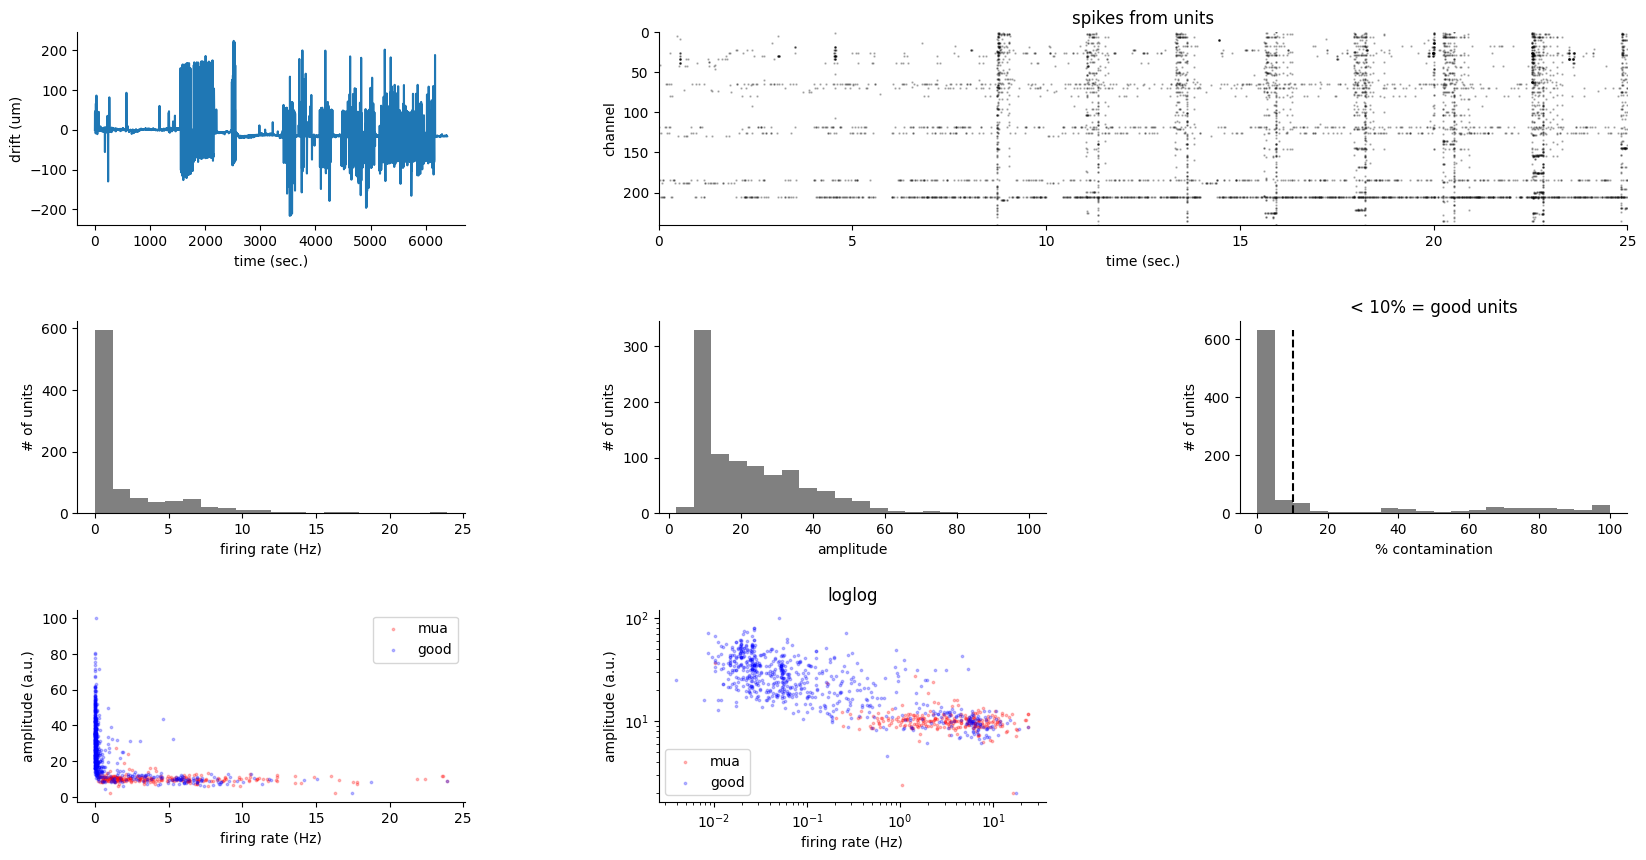

In [68]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec, rcParams
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
gray = .5 * np.ones(3)

fig = plt.figure(figsize=(20,10), dpi=100)
grid = gridspec.GridSpec(3, 3, figure=fig, hspace=0.5, wspace=0.5)

ax = fig.add_subplot(grid[0,0])
ax.plot(np.arange(0, ops['Nbatches'])*2, dshift)
ax.set_xlabel('time (sec.)')
ax.set_ylabel('drift (um)')

ax = fig.add_subplot(grid[0,1:])
t0 = 0
t1 = np.nonzero(st > ops['fs']*25)[0][0]                                                ####### change 25 to whatever time you want to plot
ax.scatter(st[t0:t1]/30000., chan_best[clu[t0:t1]], s=0.5, color='k', alpha=0.25)
ax.set_xlim([0, 25])                                                                    ####### change 25 to whatever time you want to plot
ax.set_ylim([chan_map.max(), 0])
ax.set_xlabel('time (sec.)')
ax.set_ylabel('channel')
ax.set_title('spikes from units')

ax = fig.add_subplot(grid[1,0])
nb=ax.hist(firing_rates, 20, color=gray)
ax.set_xlabel('firing rate (Hz)')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,1])
nb=ax.hist(camps, 20, color=gray)
ax.set_xlabel('amplitude')
ax.set_ylabel('# of units')

ax = fig.add_subplot(grid[1,2])
nb=ax.hist(np.minimum(100, contam_pct), np.arange(0,105,5), color=gray)
ax.plot([10, 10], [0, nb[0].max()], 'k--')
ax.set_xlabel('% contamination')
ax.set_ylabel('# of units')
ax.set_title('< 10% = good units')

for k in range(2):
    ax = fig.add_subplot(grid[2,k])
    is_ref = contam_pct<10.
    ax.scatter(firing_rates[~is_ref], camps[~is_ref], s=3, color='r', label='mua', alpha=0.25)
    ax.scatter(firing_rates[is_ref], camps[is_ref], s=3, color='b', label='good', alpha=0.25)
    ax.set_ylabel('amplitude (a.u.)')
    ax.set_xlabel('firing rate (Hz)')
    ax.legend()
    if k==1:
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title('loglog')

save_path = output_folder +"/summary.svg"
plt.savefig(save_path, dpi=300, transparent=True)

In [69]:
from collections import Counter
import pandas as pd

df = pd.DataFrame(
    {"spike_times": st[t0:t1] / 30000.0, "channel": chan_best[clu[t0:t1]]}
)

s = df.sort_values("channel")

c = Counter(s["channel"])

sorted_count = sorted(c.items(), key=lambda i: i[0])

truncated_channel = []
for i in range(len(sorted_count)):
    temp_list = [i] * sorted_count[i][1]
    truncated_channel += temp_list

In [70]:
len(chan_best)

932

In [71]:
assert len(truncated_channel) == len(s)
s["truncated_channel"] = truncated_channel

Plot raster

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# t0 = 0
# final_time = 55
# t1 = np.nonzero(st > ops["fs"] * final_time)[0][0]
# # ax.scatter(st[t0:t1] / 30000.0, chan_best[clu[t0:t1]], s=0.5, color="k", alpha=0.25)
# ax.scatter(s["spike_times"], s["truncated_channel"], s=0.3, color="k", alpha=1)
# ax.set_xlim([0, s["spike_times"].max()])
# ax.set_ylim([s["truncated_channel"].max(), 0])
# ax.set_ylim([0, s["truncated_channel"].max()])
# ax.set_xlabel("time (sec.)")
# ax.set_ylabel("channel")
# ax.set_title("spikes from units")
# save_path = output_folder +"/raster.svg"
# plt.savefig(save_path, dpi=300, transparent=True)

Plot raster + Stim onsets

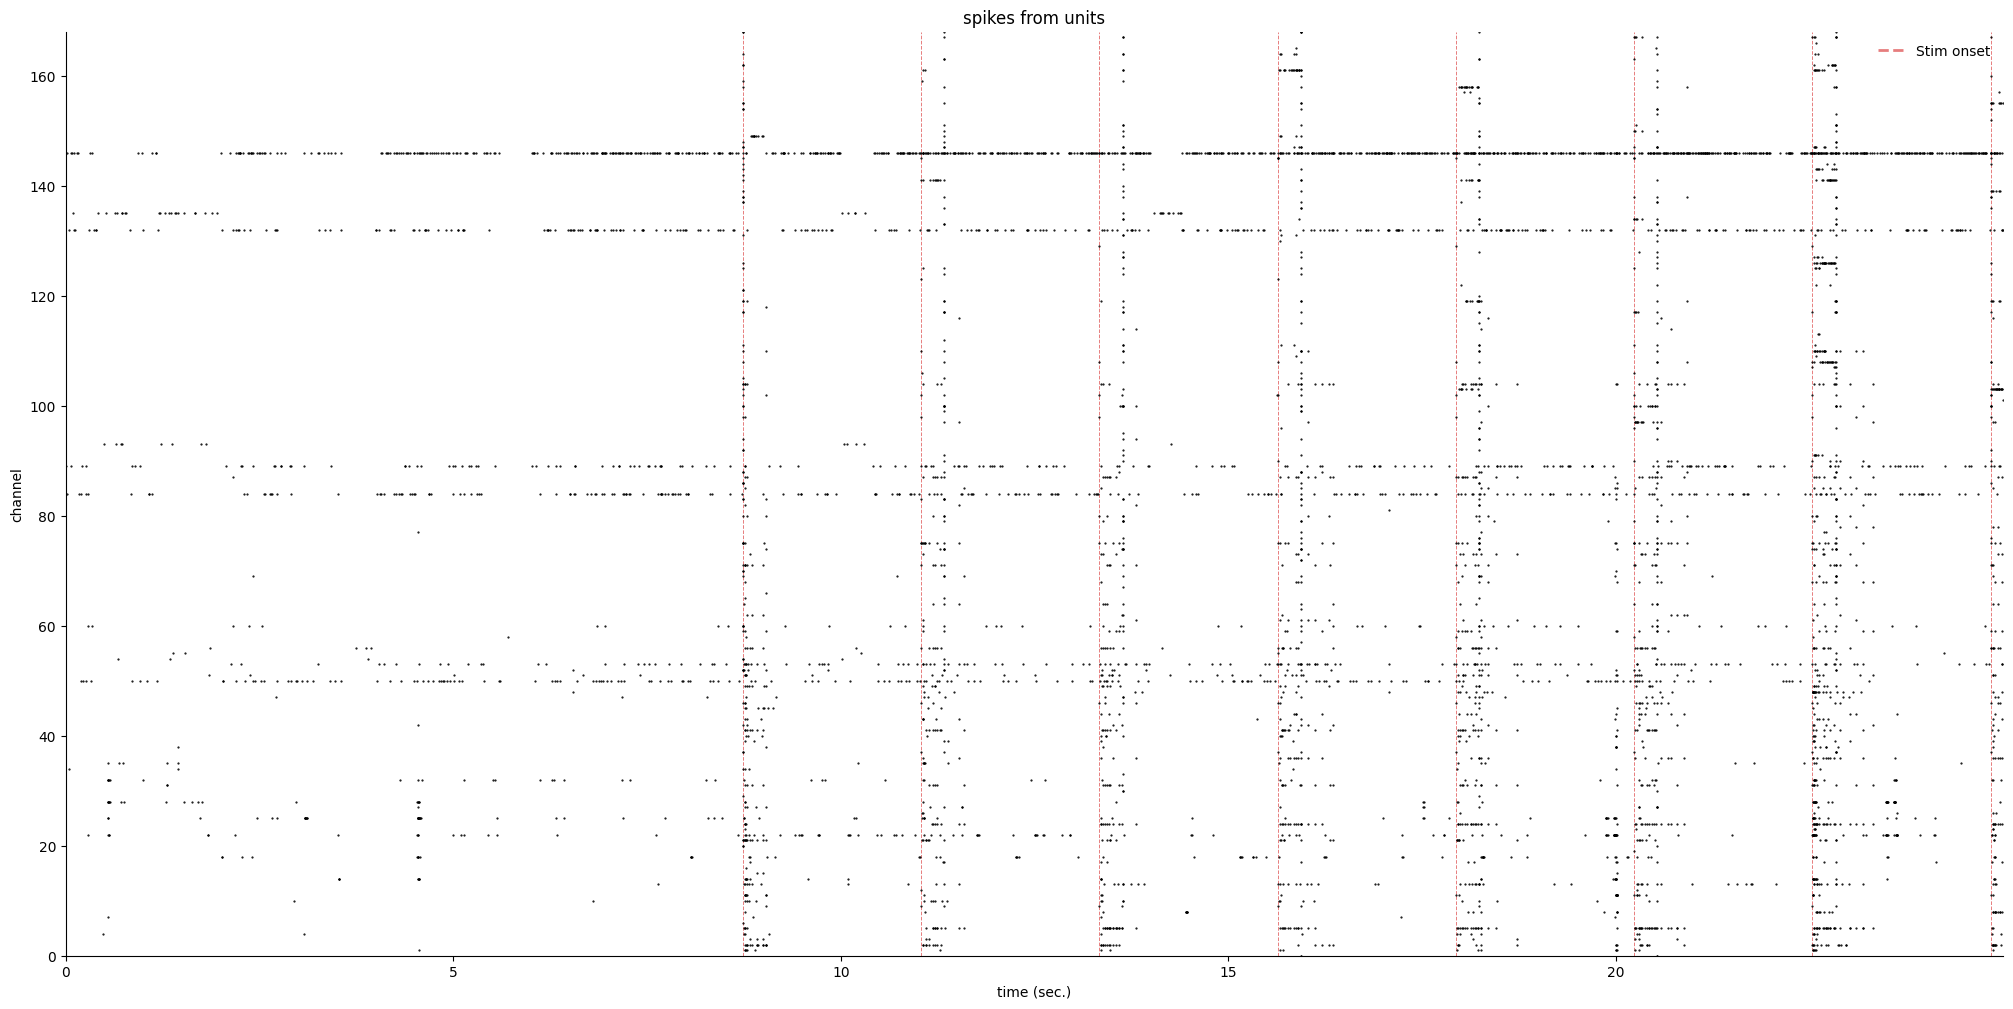

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
t0 = 0
final_time = 25                                        ####### change 55 to whatever time you want to plot
t1 = np.nonzero(st > ops["fs"] * final_time)[0][0]
# ax.scatter(st[t0:t1] / 30000.0, chan_best[clu[t0:t1]], s=0.5, color="k", alpha=0.25)
ax.scatter(s["spike_times"], s["truncated_channel"], s=0.3, color="k", alpha=1)
ax.set_xlim([0, s["spike_times"].max()])
ax.set_ylim([s["truncated_channel"].max(), 0])
ax.set_ylim([0, s["truncated_channel"].max()])
ax.set_xlabel("time (sec.)")
ax.set_ylabel("channel")
ax.set_title("spikes from units")


# --- Stim onsets as vertical lines ---
import numpy as np
from matplotlib.lines import Line2D

# Grab onsets and sampling rate
icms_onsets = get_onsets(ttl_ap_frames)
fs = float(ops.get('fs', 30000.0))

# X-axis max in seconds from your raster
xmax = float(np.asarray(s["spike_times"]).max())

# If values look like sample indices (typical), convert to seconds
if icms_onsets.dtype.kind in "iu" or np.nanmedian(icms_onsets) > xmax:
    icms_sec = icms_onsets / fs
else:
    icms_sec = icms_onsets.astype(float)

# Keep only onsets that fall within the plotted time window
mask = (icms_sec >= 0) & (icms_sec <= xmax)
icms_sec = icms_sec[mask]

# Draw vertical lines (after you've set your y-limits)
y0, y1 = ax.get_ylim()
ax.vlines(icms_sec, y0, y1, colors='tab:red', linestyles='--', linewidth=0.7, alpha=0.6, zorder=0)

# Optional legend (single proxy handle)
icms_handle = Line2D([0], [0], color='tab:red', linestyle='--', linewidth=2, alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [icms_handle], labels + ['Stim onset'], loc='upper right', frameon=False)

save_path = output_folder +"/raster_Stim.jpg" # or .png or .svg
plt.savefig(save_path, dpi=400, transparent=True)


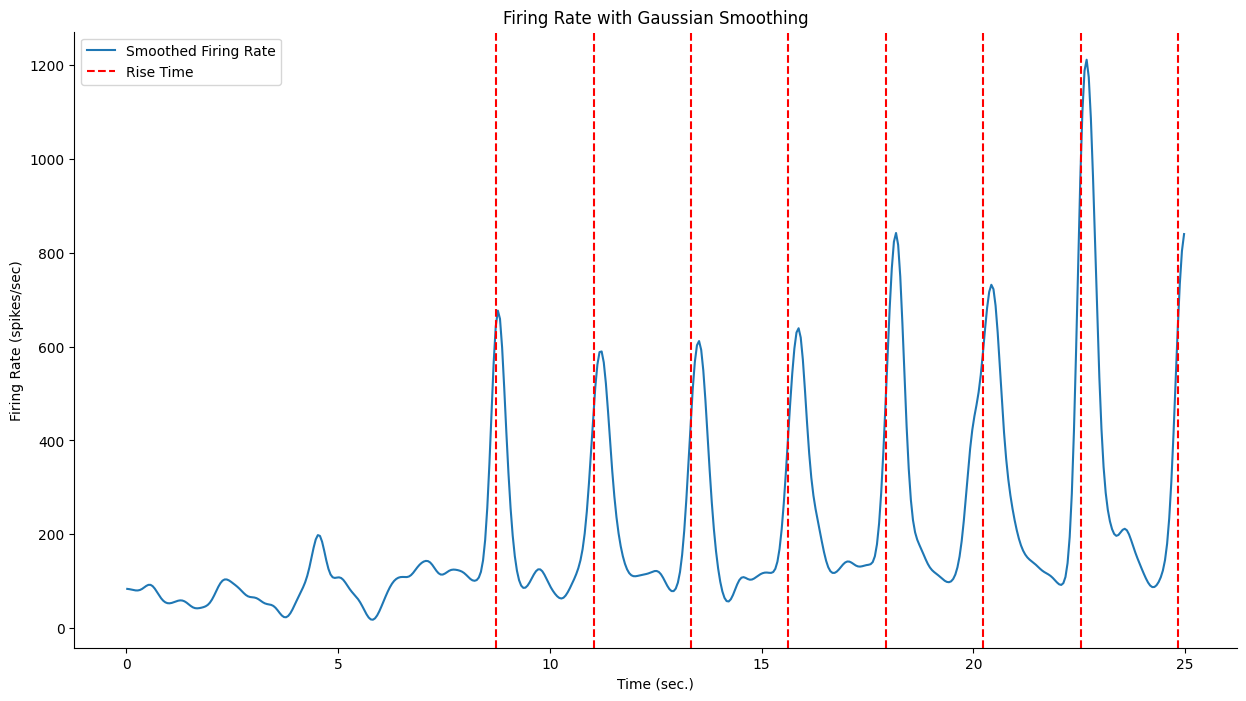

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Parameters
bin_size = 0.05  #  ms
gaussian_sigma = 3  # Standard deviation for Gaussian kernel

# Calculate the histogram (firing rate)
spike_times = s["spike_times"]
max_time = spike_times.max()
bins = np.arange(0, max_time + bin_size, bin_size)
hist, edges = np.histogram(spike_times, bins=bins)

# Convert histogram to firing rate (spikes per second)
firing_rate = hist / bin_size

# Apply Gaussian smoothing
smoothed_firing_rate = gaussian_filter1d(firing_rate, sigma=gaussian_sigma)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
time_bins = edges[:-1] + bin_size / 2  # Center of each bin

ax.plot(time_bins, smoothed_firing_rate, label='Smoothed Firing Rate')
ax.set_xlabel("Time (sec.)")
ax.set_ylabel("Firing Rate (spikes/sec)")
ax.set_title("Firing Rate with Gaussian Smoothing")

# Add vertical dashed lines for the rise times
icms_sec = get_onsets(ttl_ap_frames) / fs
for i, rise_time in enumerate(icms_sec):
    if 0 <= rise_time <= max_time:
        ax.axvline(x=rise_time, color='red', linestyle='--', label='Rise Time' if i == 0 else "")

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
save_path = output_folder +"/psth_50ms.jpg" # or .png or .svg
plt.savefig(save_path, dpi=400, transparent=True)
plt.show()



plot the average PSTH (20 ms bins) aligned to Stim onsets, averaged across neurons when s["unit_id"] is available (otherwise it shows the population rate). It handles Stim times in samples or seconds.

Saved: C:\storage\Reza\Neuropixel-pipeline\Test-Pipeline\results\08-08-2025\ICMSstim_icmsstim_All_Concat\working\ks4\sorter_output_20250901_165114/psth_avg_20ms.jpg


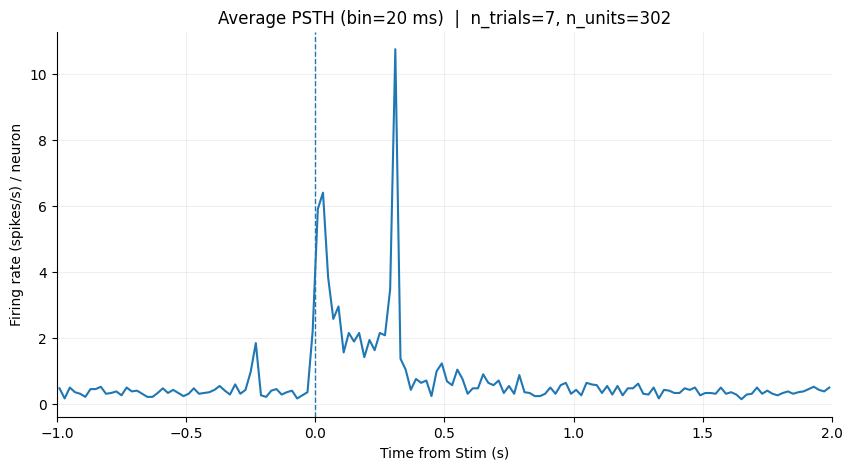

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# --------- Inputs expected ----------
# s["spike_times"] : 1D array of spike times in seconds
# s["unit_id"]     : 1D array of unit IDs (optional; same length as spike_times)
# ttl_ap_frames[''] : 1D array of Stim onset times (samples or seconds)
# ops["fs"]        : sampling rate (Hz) if Stim onsets are in samples
# output_folder    : where to save the figure
# -----------------------------------

s["unit_id"] = clu[t0:t1] 

spike_times = np.asarray(s["spike_times"], dtype=float)
icms_onsets = get_onsets(ttl_ap_frames)
fs = float(ops.get("fs", 30000.0))

# Convert Stim onsets to seconds if they look like sample indices
xmax = float(spike_times.max()) if spike_times.size else 0.0
if icms_onsets.dtype.kind in "iu" or (np.nanmedian(icms_onsets) if icms_onsets.size else 0) > xmax:
    icms_sec = icms_onsets / fs
else:
    icms_sec = icms_onsets.astype(float)

# PSTH params
bin_ms = 20
bin_width = bin_ms / 1000.0  # 10 ms
t_pre, t_post = -1, 2    # window around Stim (adjust as needed)

# Keep only Stim events with a full window inside recording
valid_mask = (icms_sec + t_pre >= 0.0) & (icms_sec + t_post <= xmax)
icms_sec = icms_sec[valid_mask]
n_trials = int(icms_sec.size)
if n_trials == 0:
    raise ValueError("No Stim onsets within the recording bounds for the chosen PSTH window.")

# Binning
edges = np.arange(t_pre, t_post + bin_width, bin_width)
centers = (edges[:-1] + edges[1:]) * 0.5

# Sort spike times for fast windowed slicing
order = np.argsort(spike_times)
st_sorted = spike_times[order]

# Accumulate counts across events without materializing all relative times
counts = np.zeros(edges.size - 1, dtype=float)
for e in icms_sec:
    start = e + t_pre
    end = e + t_post
    L = np.searchsorted(st_sorted, start, side="left")
    R = np.searchsorted(st_sorted, end, side="right")
    rel = st_sorted[L:R] - e
    if rel.size:
        counts += np.histogram(rel, bins=edges)[0]

# Normalize to firing rate (Hz)
rate = counts / (n_trials * bin_width)

# If unit IDs are available, divide by number of neurons to get average-per-neuron PSTH
if "unit_id" in s: # and len(s["unit_id"]) == len(s["spike_times"]):
    n_units = np.unique(np.asarray(s["unit_id"])).size
else:
    n_units = None

ylabel = "Firing rate (spikes/s)"
if n_units and n_units > 0:
    rate = rate / n_units
    ylabel += " / neuron"

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(centers, rate, linewidth=1.5)
ax.axvline(0.0, linestyle="--", linewidth=1.0)  # Stim onset
ax.set_xlim([t_pre, t_post])
ax.set_xlabel("Time from Stim (s)")
ax.set_ylabel(ylabel)
title_extra = f"  |  n_trials={n_trials}" + (f", n_units={n_units}" if n_units else "")
ax.set_title(f"Average PSTH (bin={bin_ms} ms){title_extra}")
ax.grid(True, alpha=0.2)

# Save
save_path = output_folder + "/psth_avg_20ms.jpg"  # or .png or .svg
plt.savefig(save_path, dpi=300, transparent=True)
print("Saved:", save_path)


~~~~~~~~~~~~~~ good units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


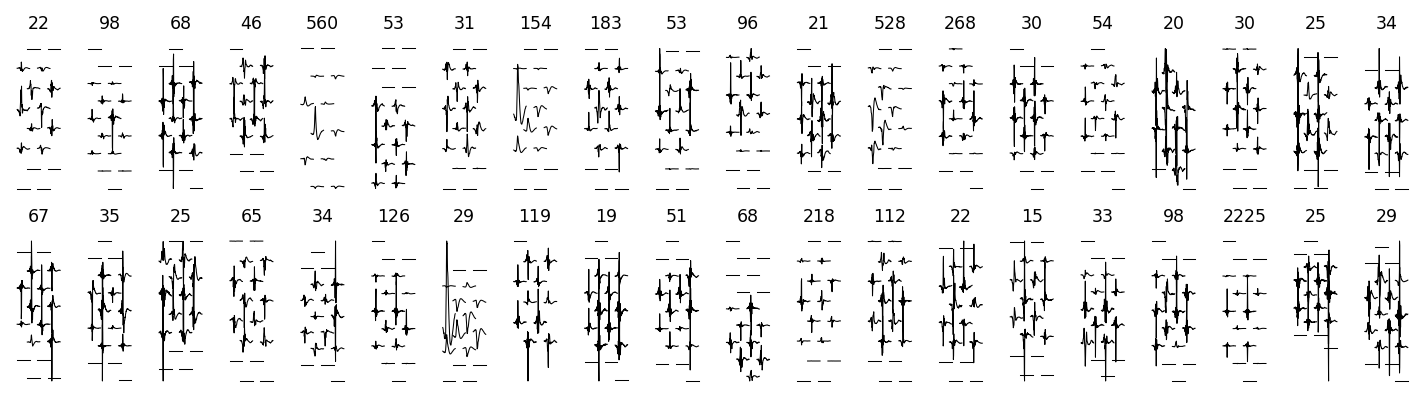

~~~~~~~~~~~~~~ mua units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
title = number of spikes from each unit


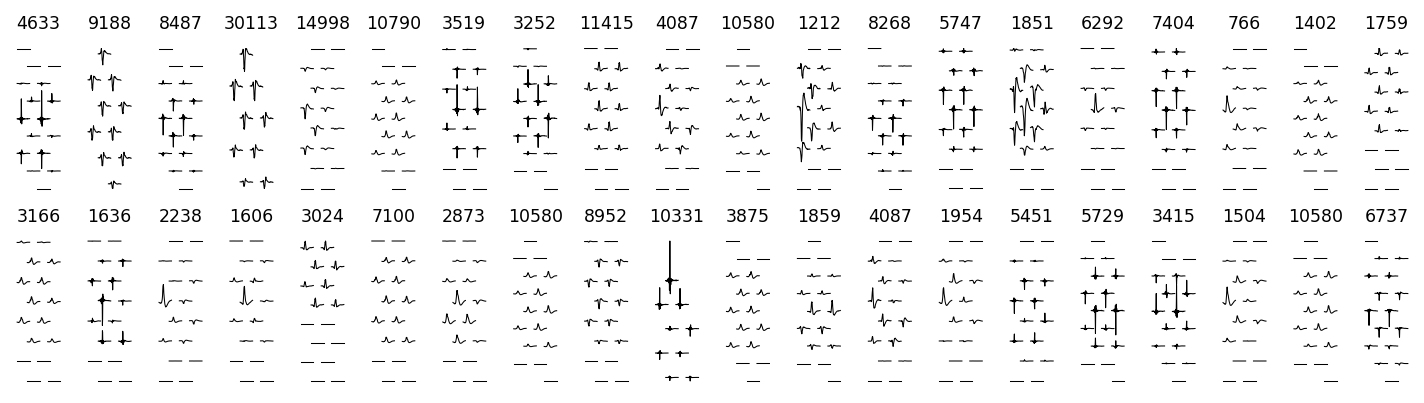

In [75]:
probe = ops["probe"]
# x and y position of probe sites
xc, yc = probe["xc"], probe["yc"]
nc = 16  # number of channels to show
good_units = np.nonzero(contam_pct <= 0.1)[0]
mua_units = np.nonzero(contam_pct > 0.1)[0]


gstr = ["good", "mua"]
for j in range(2):
    print(f"~~~~~~~~~~~~~~ {gstr[j]} units ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("title = number of spikes from each unit")
    units = good_units if j == 0 else mua_units
    fig = plt.figure(figsize=(12, 3), dpi=150)
    grid = gridspec.GridSpec(2, 20, figure=fig, hspace=0.25, wspace=0.5)

    for k in range(40):
        wi = units[np.random.randint(len(units))]
        wv = templates[wi].copy()
        cb = chan_best[wi]
        nsp = (clu == wi).sum()

        ax = fig.add_subplot(grid[k // 20, k % 20])
        n_chan = wv.shape[-1]
        ic0 = max(0, cb - nc // 2)
        ic1 = min(n_chan, cb + nc // 2)
        wv = wv[:, ic0:ic1]
        x0, y0 = xc[ic0:ic1], yc[ic0:ic1]

        amp = 4
        for ii, (xi, yi) in enumerate(zip(x0, y0)):
            t = np.arange(-wv.shape[0] // 2, wv.shape[0] // 2, 1, "float32")
            t /= wv.shape[0] / 20
            ax.plot(xi + t, yi + wv[:, ii] * amp, lw=0.5, color="k")

        ax.set_title(f"{nsp}", fontsize="small")
        ax.axis("off")
    plt.show()

In [ ]:
# sorting = se.read_kilosort(folder_path=output_folder)

In [76]:
analyzer_in_memory = si.create_sorting_analyzer(sorting, recording=rec,**job_kwargs)

estimate_sparsity (workers: 28 processes):   0%|          | 0/1279 [00:00<?, ?it/s]

In [77]:
analyzer = analyzer_in_memory.save_as(format="binary_folder", folder=output_folder+"/sorting_analyzer_output")

In [ ]:
# analyzer_path = Path("C:/storage/Reza/Neuropixel-pipeline/Test-Pipeline/results_08-08-2025/working/ks4/sorter_output_20250820_131727-RA-CAR-HSF/sorting_analyzer_output")
# analyzer = si.load_sorting_analyzer(analyzer_path)

In [78]:
required_extensions = [
    "random_spikes",
    "waveforms",
    "templates",
    "noise_levels",
    "unit_locations",
    "template_similarity",
    "spike_amplitudes",
    "correlograms"
]
analyzer.compute(required_extensions, **job_kwargs)  # Use job_kwargs to pass n_jobs
analyzer

compute_waveforms (workers: 28 processes):   0%|          | 0/1279 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

Compute : spike_amplitudes (workers: 28 processes):   0%|          | 0/1279 [00:00<?, ?it/s]

SortingAnalyzer: 241 channels - 712 units - 1 segments - binary_folder - sparse - has recording
Loaded 8 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, template_similarity, correlograms, spike_amplitudes

In [ ]:
# sorter_path = Path("C:/storage/Reza/Neuropixel-pipeline/Test-Pipeline/results_08-08-2025/working/ks4/sorter_output_20250820_131727-RA-CAR-HSF/sorter_output")
# sorting = se.read_kilosort(sorter_path)

In [79]:
num_spikes = sorting.count_num_spikes_per_unit()
unit_amplitudes = si.get_template_extremum_amplitude(analyzer)

analyzer.sorting.set_property("num_spikes", list(num_spikes.values()))
analyzer.sorting.set_property("amplitude", list(unit_amplitudes.values()))

In [ ]:
# ! pip install --upgrade sortingview
# ! pip install jupyter extension

In [ ]:
# w = sw.plot_sorting_summary(
#     analyzer,
#     unit_table_properties=["num_spikes", "amplitude"], 
#     curation=True, 
#     label_choices=["noise", "MUA", "SUA"],
#     backend="spikeinterface_gui"  # or "spikeinterface_gui" "sortingview" if you prefer
# )


In [80]:
analyzer.compute("principal_components", n_components=3, mode="by_channel_global")
analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate", "isi_violation", "amplitude_cutoff", "presence_ratio", "isolation_distance"], **job_kwargs)

Fitting PCA:   0%|          | 0/712 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/712 [00:00<?, ?it/s]

c:\storage\Reza\Neuropixel-pipeline\venv\Lib\site-packages\spikeinterface\qualitymetrics\misc_metrics.py:1066: UserWarning: Some units have too few spikes : amplitude_cutoff is set to NaN
  warnings.warn(f"Some units have too few spikes : amplitude_cutoff is set to NaN")


calculate_pc_metrics:   0%|          | 0/712 [00:00<?, ?it/s]

c:\storage\Reza\Neuropixel-pipeline\venv\Lib\site-packages\pandas\core\dtypes\cast.py:1058: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\storage\Reza\Neuropixel-pipeline\venv\Lib\site-packages\pandas\core\dtypes\cast.py:1082: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [81]:
analyzer= analyzer.save_as(
    folder=output_folder+"/sorting_analyzer_output, overwrite=True",
)

In [ ]:
# ! pip install --upgrade spikeinterface_gui

In [ ]:
# from spikeinterface_gui import run_mainwindow
# # open and run the Qt app
# run_mainwindow(analyzer_saved, mode="desktop")
# # open and run the Web app
# run_mainwindow(analyzer_saved, mode="web")

In [ ]:
# sw.plot_sorting_summary(analyzer, curation=True, backend="spikeinterface_gui")

In [82]:
extensions_to_compute = {
    
    'amplitude_scalings': {},
    'spike_locations': {},
    'template_metrics': {},
}

analyzer.compute(extensions_to_compute, **job_kwargs) 

c:\storage\Reza\Neuropixel-pipeline\venv\Lib\site-packages\spikeinterface\postprocessing\template_metrics.py:644: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  res = scipy.stats.linregress(times[peak_idx:max_idx], template_single[peak_idx:max_idx])


Compute : amplitude_scalings + spike_locations (workers: 28 processes):   0%|          | 0/1279 [00:00<?, ?it/…

In [83]:
analyzer= analyzer.save_as(
    folder=output_folder+"/sorting_analyzer_output, overwrite=True",
)

In [ ]:
sw.plot_sorting_summary(analyzer, curation=True, backend="spikeinterface_gui")

In [84]:
analyzer

SortingAnalyzer: 241 channels - 712 units - 1 segments - memory - sparse - has recording
Loaded 13 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, template_similarity, correlograms, spike_amplitudes, principal_components, template_metrics, amplitude_scalings, spike_locations, quality_metrics

In [85]:
# # 6) Waveforms & Quality Metrics
metrics, good_units = run_qc_with_analyzer(
    analyzer,
    qc_rules=QC_RULES
)

In [86]:
print("Total units:", len(metrics))
print("Good units:", len(good_units))
print("Good unit IDs:", good_units)
print(metrics.head())

Total units: 712
Good units: 10
Good unit IDs: [172, 220, 274, 361, 365, 469, 490, 730, 731, 810]
         snr  firing_rate  isi_violations_ratio  isi_violations_count  \
0  28.648562     0.025819                   0.0                   0.0   
1  43.258456     0.021907                   0.0                   0.0   
2  18.717580     0.014866                   0.0                   0.0   
3  17.743855     1.093807                   0.0                   0.0   
4  12.768502     0.054769                   0.0                   0.0   

   amplitude_cutoff  presence_ratio  isolation_distance  
0               NaN        0.047619        3.711722e+03  
1               NaN        0.047619        3.879339e+16  
2               NaN        0.047619        4.114136e+14  
3          0.032475        0.619048        5.790906e+01  
4               NaN        0.047619        6.616833e+02  


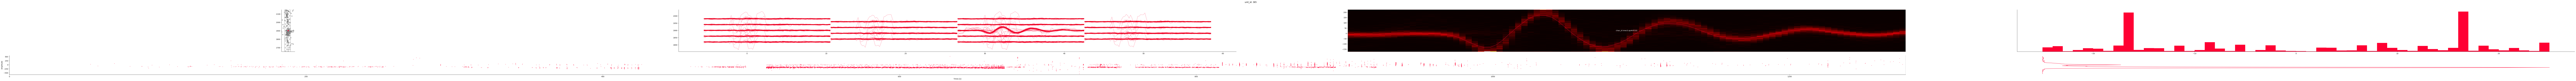

In [91]:
sw.plot_unit_summary(analyzer, unit_id=365, figsize=(274,7))

In [ ]:
sw.plot_unit_templates(analyzer, unit_ids=[43,128])

In [ ]:
sw.plot_crosscorrelograms(analyzer.sorting,  unit_ids=[0,252])

In [ ]:
%matplotlib widget
sw.plot_amplitudes(analyzer, plot_histograms=True, backend="ipywidgets")

In [ ]:
sw.plot_all_amplitudes_distributions(analyzer, figsize=(10,8))

Saved: C:\storage\Reza\Neuropixel-pipeline\Test-Pipeline\results\08-08-2025\ICMSstim_icmsstim_All_Concat\working\ks4\sorter_output_20250901_165114/raster_Stim_good_units.jpg


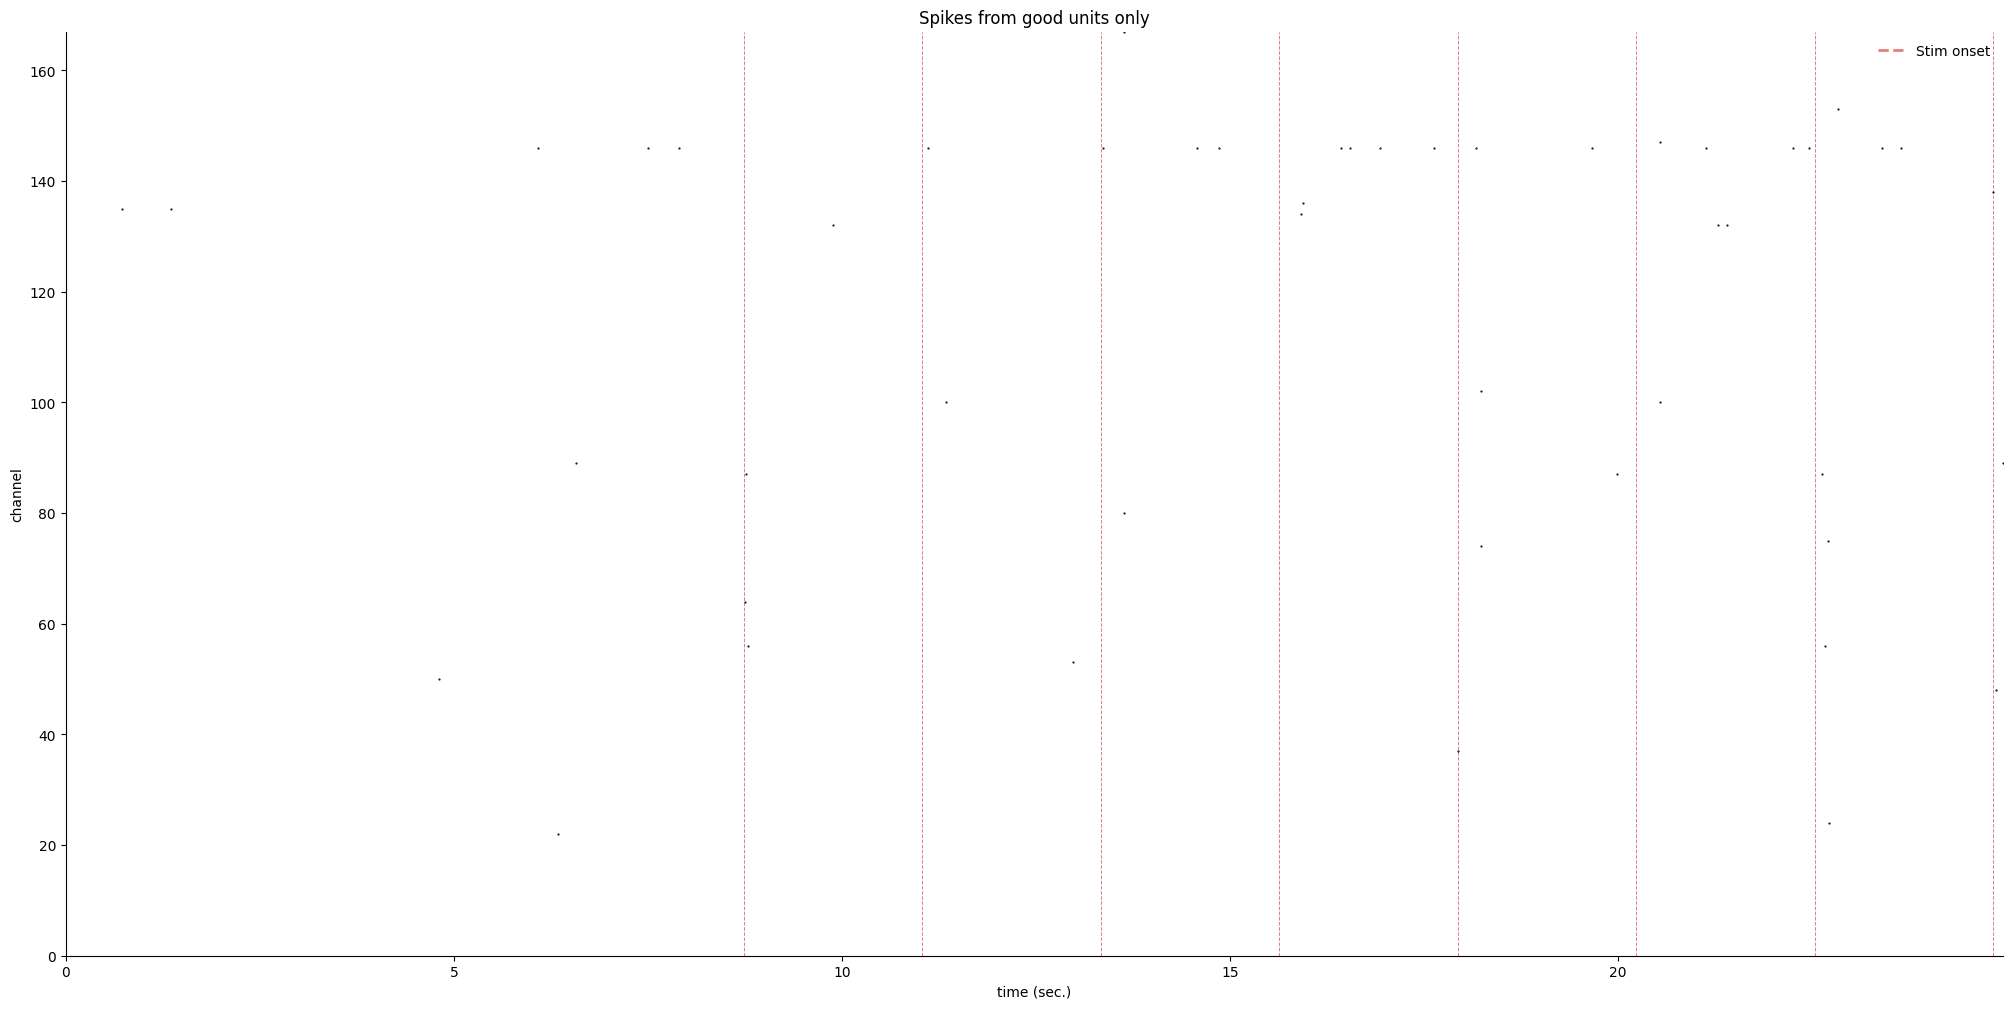

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ---- Filter spikes to good units ----
# good_units: iterable of unit IDs you want to keep (e.g., from QC)
if "unit_id" not in s:
    raise KeyError("s['unit_id'] is required (per-spike unit IDs) to filter by good_units.")

spike_times_all = np.asarray(s["spike_times"], dtype=float)
unit_ids_all   = np.asarray(s["unit_id"])
chan_all       = np.asarray(s["truncated_channel"])

# Optional time window limit (seconds)
final_time = 55.0
time_mask = spike_times_all <= final_time

good_units = np.asarray(good_units)  # provided by you
good_mask = np.isin(unit_ids_all, good_units)

mask = time_mask & good_mask

if not np.any(mask):
    raise ValueError("No spikes match the selected good_units (within the time window).")

spike_times = spike_times_all[mask]
trunc_chan  = chan_all[mask]

# ---- Plot raster (good units only) ----
fig, ax = plt.subplots(1, 1, figsize=(25, 12))
ax.scatter(spike_times, trunc_chan, s=0.3, color="k", alpha=1)

ax.set_xlim(0, float(spike_times.max()))
ax.set_ylim(0, float(trunc_chan.max()))
ax.set_xlabel("time (sec.)")
ax.set_ylabel("channel")
ax.set_title("Spikes from good units only")

# ---- Stim onsets as vertical lines ----
icms_onsets = get_onsets(ttl_ap_frames)
fs = float(ops.get('fs', 30000.0))

xmax = float(spike_times_all.max()) if spike_times_all.size else float(spike_times.max())

# Convert to seconds if values look like sample indices
if icms_onsets.dtype.kind in "iu" or (np.nanmedian(icms_onsets) if icms_onsets.size else 0) > xmax:
    icms_sec = icms_onsets / fs
else:
    icms_sec = icms_onsets.astype(float)

# Keep only onsets within the plotted window
mask_icms = (icms_sec >= 0) & (icms_sec <= final_time)
icms_sec = icms_sec[mask_icms]

# Draw lines after y-limits set
y0, y1 = ax.get_ylim()
ax.vlines(icms_sec, y0, y1, colors='tab:red', linestyles='--', linewidth=0.7, alpha=0.6, zorder=0)

# Legend
icms_handle = Line2D([0], [0], color='tab:red', linestyle='--', linewidth=2, alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [icms_handle], labels + ['Stim onset'], loc='upper right', frameon=False)

# ---- Save ----
save_path = output_folder + "/raster_Stim_good_units.jpg"  # or .png/.svg
plt.savefig(save_path, dpi=400, transparent=True)
print("Saved:", save_path)


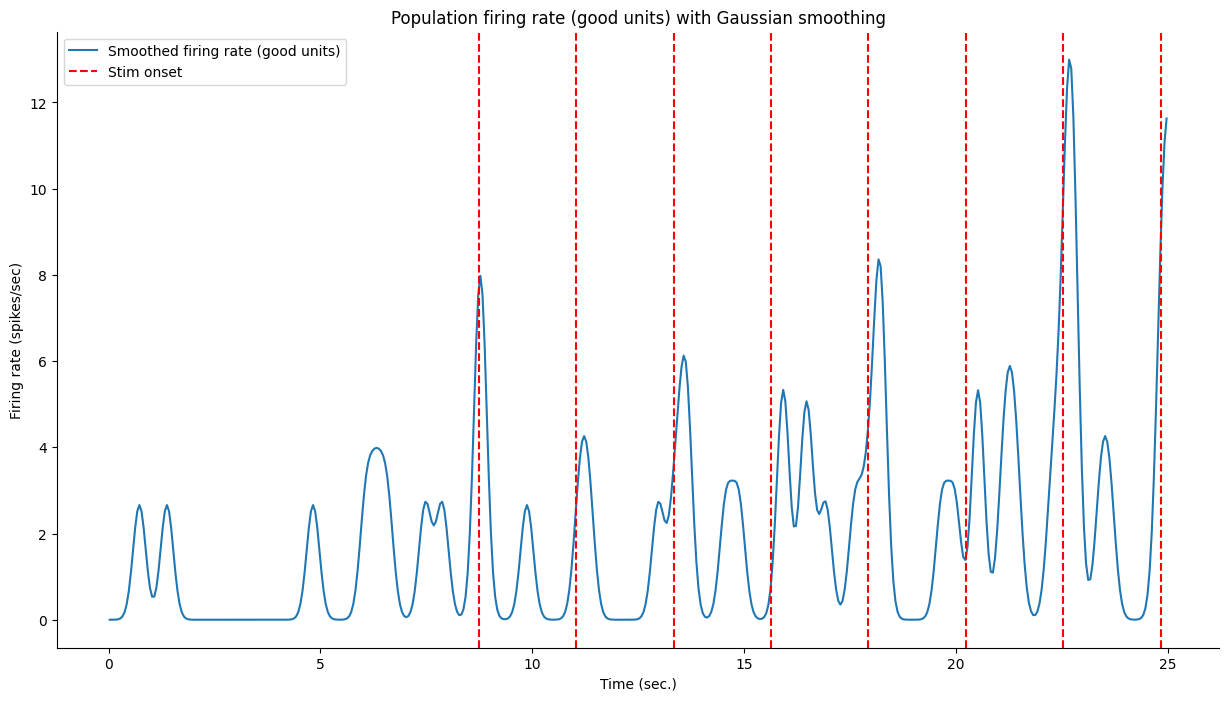

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# -------- Inputs expected ----------
# good_units           : iterable of "good" unit IDs
# s["spike_times"]     : 1D array (seconds)
# s["unit_id"]         : 1D array (per-spike unit IDs; same length as spike_times)
# ttl_ap_frames[""]: 1D array (Stim onsets; in samples or seconds)
# ops["fs"]            : sampling rate (Hz) if Stim onsets are in samples
# -----------------------------------

# Parameters
bin_size = 0.05          # seconds 
gaussian_sigma = 3       # std of Gaussian (in bins, not seconds)

# ---- Filter to good units ----
if "unit_id" not in s:
    raise KeyError("s['unit_id'] (per-spike unit labels) is required to filter by good_units.")

spike_times_all = np.asarray(s["spike_times"], dtype=float)
unit_ids_all    = np.asarray(s["unit_id"])
good_units      = np.asarray(good_units)

if spike_times_all.shape[0] != unit_ids_all.shape[0]:
    raise ValueError("s['spike_times'] and s['unit_id'] must have the same length.")

mask = np.isin(unit_ids_all, good_units)
if not np.any(mask):
    raise ValueError("No spikes from the provided good_units.")
spike_times = spike_times_all[mask]

# ---- Histogram & smoothing (population firing rate of good units) ----
max_time = float(spike_times.max())
bins = np.arange(0.0, max_time + bin_size, bin_size)
hist, edges = np.histogram(spike_times, bins=bins)

# Convert histogram to firing rate (spikes/s)
firing_rate = hist / bin_size

# Apply Gaussian smoothing (sigma in bins)
smoothed_firing_rate = gaussian_filter1d(firing_rate, sigma=gaussian_sigma)

# ---- Stim onsets -> seconds (robust) ----
fs = float(ops.get("fs", 30000.0))
icms_raw = get_onsets(ttl_ap_frames)
xmax_all = float(spike_times_all.max()) if spike_times_all.size else max_time

if icms_raw.dtype.kind in "iu" or (np.nanmedian(icms_raw) if icms_raw.size else 0) > xmax_all:
    icms_sec = icms_raw / fs
else:
    icms_sec = icms_raw.astype(float)

# ---- Plot ----
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
time_bins = edges[:-1] + bin_size / 2.0  # center of each bin

ax.plot(time_bins, smoothed_firing_rate, label='Smoothed firing rate (good units)')

ax.set_xlabel("Time (sec.)")
ax.set_ylabel("Firing rate (spikes/sec)")
ax.set_title("Population firing rate (good units) with Gaussian smoothing")

# Add vertical dashed lines for Stim onsets that fall in the plotted range
first_line_drawn = False
for rt in icms_sec:
    if 0 <= rt <= max_time:
        ax.axvline(x=rt, color='red', linestyle='--',
                   label='Stim onset' if not first_line_drawn else "")
        first_line_drawn = True

# Deduplicate legend labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
save_path = output_folder +"/psth_good_units_50ms.jpg" # or .png or .svg
plt.savefig(save_path, dpi=400, transparent=True)
plt.show()


psth of a single unit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# -------- Inputs expected ----------
# s["spike_times"]      : 1D array (seconds)
# s["unit_id"]          : 1D array (per-spike unit IDs; same length as spike_times)
# ttl_ap_frames[""] : 1D array (Stim onsets; in samples or seconds)
# ops["fs"]             : sampling rate (Hz) if Stim onsets are in samples
# ops["nSamples"]       : (optional) total AP samples for recording duration
# -----------------------------------

# Target neuron (unit/cluster id)
target_unit = 43

# Parameters
bin_size = 0.1          # seconds (20 ms)
gaussian_sigma = 4       # std of Gaussian (in bins)

# --- Select spikes from the target neuron ---
if "unit_id" not in s:
    raise KeyError("s['unit_id'] (per-spike unit labels) is required.")

spike_times_all = np.asarray(s["spike_times"], dtype=float)
unit_ids_all    = np.asarray(s["unit_id"])

if spike_times_all.shape[0] != unit_ids_all.shape[0]:
    raise ValueError("s['spike_times'] and s['unit_id'] must have the same length.")

mask = (unit_ids_all == target_unit)
if not np.any(mask):
    raise ValueError(f"No spikes found for unit {target_unit}.")

spike_times = spike_times_all[mask]

# --- Determine recording duration ---
fs = float(ops.get("fs", 30000.0))
if "nSamples" in ops:
    recording_end_sec = float(ops["nSamples"]) / fs
else:
    # fallback: use the maximum spike time seen in the whole recording
    recording_end_sec = float(spike_times_all.max())

# --- Histogram & smoothing for this neuron ---
bins = np.arange(0.0, recording_end_sec + bin_size, bin_size)
hist, edges = np.histogram(spike_times, bins=bins)

# Convert histogram to firing rate (spikes/s)
firing_rate = hist / bin_size

# Apply Gaussian smoothing (sigma in bins)
smoothed_firing_rate = gaussian_filter1d(firing_rate, sigma=gaussian_sigma)

# --- ICMS onsets -> seconds (robust) ---
icms_raw = get_onsets(ttl_ap_frames)
xmax_ref = recording_end_sec
if icms_raw.dtype.kind in "iu" or (np.nanmedian(icms_raw) if icms_raw.size else 0) > xmax_ref:
    icms_sec = icms_raw / fs
else:
    icms_sec = icms_raw.astype(float)

# --- Plot ---
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
time_bins = edges[:-1] + bin_size / 2.0  # center of each bin

ax.plot(time_bins, smoothed_firing_rate, label=f'Unit {target_unit} (smoothed)')
ax.set_xlabel("Time (sec.)")
ax.set_ylabel("Firing rate (spikes/sec)")
ax.set_title(f"Firing rate with Gaussian smoothing — unit {target_unit}")

# Add vertical dashed lines for Stim onsets within range
first_line_drawn = False
for rt in icms_sec:
    if 0 <= rt <= recording_end_sec:
        ax.axvline(x=rt, color='red', linestyle='--',
                   label='Stim onset' if not first_line_drawn else "")
        first_line_drawn = True

# Deduplicate legend labels
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------- Inputs expected ----------
# good_units        : iterable of "good" unit IDs (from your QC step)
# s["spike_times"]  : 1D array of spike times in seconds
# s["unit_id"]      : 1D array of per-spike unit IDs (same length as spike_times)
# ttl_ap_frames['ims'] : 1D array of Stim onset times (samples or seconds)
# ops["fs"]         : sampling rate (Hz) if Stim onsets are in samples
# output_folder     : where to save the figure
# -----------------------------------

# (If needed) ensure per-spike unit labels exist
s["unit_id"] = clu[t0:t1]  # your original line (keep if needed)

spike_times_all = np.asarray(s["spike_times"], dtype=float)
unit_ids_all    = np.asarray(s["unit_id"])
if spike_times_all.shape[0] != unit_ids_all.shape[0]:
    raise ValueError("s['spike_times'] and s['unit_id'] must have the same length.")

# ---- keep only good units ----
good_units = np.asarray(good_units)
if good_units.size == 0:
    raise ValueError("good_units is empty.")

good_mask = np.isin(unit_ids_all, good_units)
if not np.any(good_mask):
    raise ValueError("No spikes from the provided good_units.")

spike_times = spike_times_all[good_mask]
n_units_good = np.unique(unit_ids_all[good_mask]).size

# ---- Stim onsets (seconds) ----
icms_onsets = get_onsets(ttl_ap_frames)
fs = float(ops.get("fs", 30000.0))

# Use the global spike-time max as a proxy for recording end if no better info is available
xmax_all = float(spike_times_all.max()) if spike_times_all.size else 0.0

# Convert to seconds if they look like sample indices
if icms_onsets.dtype.kind in "iu" or (np.nanmedian(icms_onsets) if icms_onsets.size else 0) > xmax_all:
    icms_sec = icms_onsets / fs
else:
    icms_sec = icms_onsets.astype(float)

# If you know total recording duration, use it here; else fall back to xmax_all
recording_end_sec = float(ops.get("nSamples", 0)) / fs if "nSamples" in ops else xmax_all

# PSTH params
bin_ms = 20
bin_width = bin_ms / 1000.0
t_pre, t_post = -1.0, 2.0

# Keep only Stim events with a full window inside recording
valid_mask = (icms_sec + t_pre >= 0.0) & (icms_sec + t_post <= recording_end_sec)
icms_sec = icms_sec[valid_mask]
n_trials = int(icms_sec.size)
if n_trials == 0:
    raise ValueError("No Stim onsets with a full window inside recording for the chosen PSTH window.")

# Binning
edges = np.arange(t_pre, t_post + bin_width, bin_width)
centers = 0.5 * (edges[:-1] + edges[1:])

# Sort good-unit spikes for fast slicing
st_sorted = np.sort(spike_times)

# Accumulate counts across events
counts = np.zeros(edges.size - 1, dtype=float)
for e in icms_sec:
    start, end = e + t_pre, e + t_post
    L = np.searchsorted(st_sorted, start, side="left")
    R = np.searchsorted(st_sorted, end,   side="right")
    rel = st_sorted[L:R] - e
    if rel.size:
        counts += np.histogram(rel, bins=edges)[0]

# Normalize to firing rate (Hz) and per neuron (good units only)
rate = counts / (n_trials * bin_width)
rate = rate / max(n_units_good, 1)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(centers, rate, linewidth=1.5)
ax.axvline(0.0, linestyle="--", linewidth=1.0)  # Stim onset
ax.set_xlim([t_pre, t_post])
ax.set_xlabel("Time from Stim (s)")
ax.set_ylabel("Firing rate (spikes/s) / neuron")
ax.set_title(f"Average PSTH (good units only, bin={bin_ms} ms)  |  n_trials={n_trials}, n_units={n_units_good}")
ax.grid(True, alpha=0.2)

# Save
save_path = output_folder + "/psth_avg_20ms_good_units.jpg"  # or .png/.svg
plt.savefig(save_path, dpi=300, transparent=True)
print("Saved:", save_path)


In [ ]:

# # 6) Waveforms & Quality Metrics
# we = si.extract_waveforms(
#     rec, sorting,
#     folder=str(output_folder+"/waveforms1"),
#     max_spikes_per_unit=2000,
#     overwrite=None,
#     **job_kwargs,
# )
# metrics, good_units = compute_qc_and_select(we)

In [ ]:
# 7) PSTHs per condition
fs_ap = rec.get_sampling_frequency()
stim_times = {k: v / fs_ap for k, v in ttl_ap_frames.items()}
psth, bins = make_psths(
    sorting,
    stim_times_s=stim_times,
    window_s=(-0.05, 0.20),
    bin_s=0.001,
    out_csv=True,
)


In [ ]:
# 8) Exports (Phy)
# export_results(we, sorting, good_units)
export_results(analyzer, good_units)

In [ ]:
# 8) Exports (Phy + NWB)

from pathlib import Path
from datetime import datetime, timezone
from pynwb import NWBHDF5IO

# Import helpers (handle old vs new names)
try:
    from neuroconv.tools.spikeinterface import (
        write_recording_to_nwbfile,
        add_sorting_to_nwbfile,
    )
except ImportError:
    from neuroconv.tools.spikeinterface import (
        write_recording as write_recording_to_nwbfile,
        add_sorting as add_sorting_to_nwbfile,
    )

# --- Metadata ---
metadata = {
    "NWBFile": {
        "session_description": "Neuropixels spinal cord with opto / ICMS / radial-nerve stim",
        "identifier": f"session-{datetime.now(timezone.utc).strftime('%Y%m%d-%H%M%S')}",
        "session_start_time": datetime.now(timezone.utc),
    },
}

# --- Paths ---
OUT_PATH = OUT_DIR / "nwb" / "session.nwb"
OUT_PATH.parent.mkdir(parents=True, exist_ok=True)
if OUT_PATH.exists():
    OUT_PATH.unlink()  # emulate overwrite

# --- Build NWB in memory, then write once ---
# 1) Create NWBFile with the recording
nwbfile = write_recording_to_nwbfile(
    recording=rec,          # SpikeInterface RecordingExtractor
    metadata=metadata,      # minimal NWBFile metadata
    # no nwbfile_path here -> returns an in-memory NWBFile
)

# 2) Add sorting to the same in-memory NWBFile
add_sorting_to_nwbfile(
    sorting=sorting,        # SpikeInterface SortingExtractor
    nwbfile=nwbfile,        # <-- IMPORTANT: in-memory object, not a path
    # unit_electrode_indices=...  # optional: map units to electrode indices
)

# 3) Write to disk
with NWBHDF5IO(str(OUT_PATH), "w") as io:
    io.write(nwbfile)

print("Wrote:", OUT_PATH)
